In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading data
df=pd.read_csv('payment_fraud.csv')

In [3]:
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   Category              39126 non-null  object 
 6   isWeekend             38661 non-null  float64
 7   label                 39221 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.4+ MB


In [5]:
#handling null value
df.isnull().sum()


accountAgeDays            0
numItems                  0
localTime                 0
paymentMethod             0
paymentMethodAgeDays      0
Category                 95
isWeekend               560
label                     0
dtype: int64

In [6]:
'''#df.dropna(inplace=True)
df = df.dropna()
df = df.drop_duplicates()''' # removal will not help as potential fraud data label=1 get lost significantly
df.fillna({'Category': df['Category'].mode()[0]}, inplace=True)
df.fillna({'isWeekend': df['isWeekend'].mode()[0]}, inplace=True)

In [7]:
df.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0


In [8]:
df.isnull().sum()

accountAgeDays          0
numItems                0
localTime               0
paymentMethod           0
paymentMethodAgeDays    0
Category                0
isWeekend               0
label                   0
dtype: int64

In [9]:
#since category and paymentmethod is object type and contain string we use one hot encoding to convert this data 
from sklearn.preprocessing import OneHotEncoder
encoder1=OneHotEncoder()
encoder2=OneHotEncoder()
encoded1=encoder1.fit_transform(df[['Category']]).toarray()
encoded2=encoder2.fit_transform(df[['paymentMethod']]).toarray()
encoded_df1 = pd.DataFrame(encoded1, columns=encoder1.get_feature_names_out(), index=df.index)
encoded_df2 = pd.DataFrame(encoded2, columns=encoder2.get_feature_names_out(), index=df.index)
df = pd.concat([df.drop('Category', axis=1), encoded_df1], axis=1)
df = pd.concat([df.drop('paymentMethod', axis=1), encoded_df2], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accountAgeDays             39221 non-null  int64  
 1   numItems                   39221 non-null  int64  
 2   localTime                  39221 non-null  float64
 3   paymentMethodAgeDays       39221 non-null  float64
 4   isWeekend                  39221 non-null  float64
 5   label                      39221 non-null  int64  
 6   Category_electronics       39221 non-null  float64
 7   Category_food              39221 non-null  float64
 8   Category_shopping          39221 non-null  float64
 9   paymentMethod_creditcard   39221 non-null  float64
 10  paymentMethod_paypal       39221 non-null  float64
 11  paymentMethod_storecredit  39221 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 3.6 MB


In [11]:
#checking for data imbalance 
print(df['label'].value_counts())

label
0    38661
1      560
Name: count, dtype: int64


In [12]:
# observation : data is imbalance so , using upsampling for making data balance 
df_minority=df[df['label']==1]
df_majority=df[df['label']==0]

from sklearn.utils import resample 
# it is use to create new data point for up sampling
df_minority_resample=resample(df_minority,replace=True,n_samples=len(df_majority))

df_upsampled=pd.concat([df_minority_resample,df_majority])
print("upsampled data frame",df_upsampled.head())
print("label value count after upscaling",df_upsampled['label'].value_counts())


upsampled data frame        accountAgeDays  ...  paymentMethod_storecredit
34472               1  ...                        0.0
18251               1  ...                        0.0
10155               1  ...                        0.0
21463               1  ...                        0.0
8778                1  ...                        0.0

[5 rows x 12 columns]
label value count after upscaling label
1    38661
0    38661
Name: count, dtype: int64


In [13]:
df_upsampled.head()

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,isWeekend,label,Category_electronics,Category_food,Category_shopping,paymentMethod_creditcard,paymentMethod_paypal,paymentMethod_storecredit
34472,1,1,4.895263,0.022222,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0
18251,1,1,3.954522,0.000000,0.0,1,0.0,1.0,0.0,1.0,0.0,0.0
10155,1,1,4.921349,0.000694,0.0,1,0.0,1.0,0.0,1.0,0.0,0.0
21463,1,1,4.886641,0.000000,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0
8778,1,1,4.895263,0.000000,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
df_upsampled['label'].value_counts()

label
1    38661
0    38661
Name: count, dtype: int64

Text(0.5, 1.0, 'Correlation matrix')

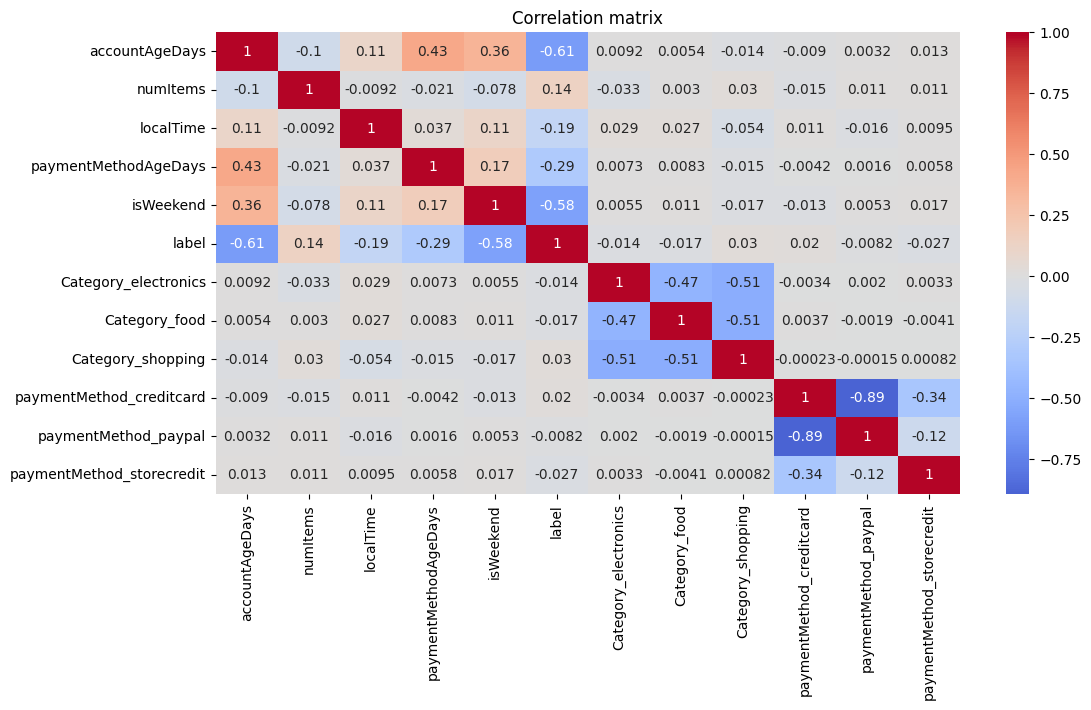

In [15]:
#correlation matrix 
plt.figure(figsize=(12,6))
sns.heatmap(df_upsampled.corr(),
           annot=True,
           center=0,
           cmap='coolwarm')
plt.title("Correlation matrix")

In [16]:
#creating dependent and independent features
X=df_upsampled.drop('label',axis=1)
y=df_upsampled['label']

In [17]:
#standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [19]:
#preforming logistic regression 
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [20]:
# preformance metric
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("accuracy",accuracy_score(y_pred,y_test))
print("confusion_matrix",confusion_matrix(y_pred,y_test))
print("classification_report",classification_report(y_test,y_pred))

accuracy 0.9564947493663029
confusion_matrix [[8818    0]
 [ 841 9672]]
classification_report               precision    recall  f1-score   support

           0       1.00      0.91      0.95      9659
           1       0.92      1.00      0.96      9672

    accuracy                           0.96     19331
   macro avg       0.96      0.96      0.96     19331
weighted avg       0.96      0.96      0.96     19331



In [21]:
#hyper parameter tuning
from sklearn.model_selection import GridSearchCV,StratifiedKFold
model=LogisticRegression()
penalty=['l1','l2','elasticnet']
c_value=[100,10,0.1,0.01,1]
solver=['newton-cg','saga','sag','liblinear','lbfgs']
params=dict(penalty=penalty,C=c_value,solver=solver)
cv=StratifiedKFold()
grid=GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=cv)
grid.fit(X_train,y_train)


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

,estimator,LogisticRegression()
,param_grid,"{'C': [100, 10, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['newton-cg', 'saga', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [22]:
y_pred_grid=grid.predict(X_test)
print('best parameters',grid.best_params_)
print('best score',grid.best_score_)
print("classification report",classification_report(y_test,y_pred_grid))
print("confusion_matrix",confusion_matrix(y_test,y_pred_grid))

best parameters {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
best score 0.982359366388463
classification report               precision    recall  f1-score   support

           0       1.00      0.95      0.98      9659
           1       0.95      1.00      0.98      9672

    accuracy                           0.98     19331
   macro avg       0.98      0.98      0.98     19331
weighted avg       0.98      0.98      0.98     19331

confusion_matrix [[9192  467]
 [   0 9672]]


In [27]:
#implementing using knn
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)


In [28]:
#preformance metrics
y_pred_knn=grid.predict(X_test)
print("accuracy score",accuracy_score(y_test,y_pred_knn))
print("classification report",classification_report(y_test,y_pred_knn))
print("confusion_matrix",confusion_matrix(y_test,y_pred_knn))

accuracy score 0.9758419119548911
classification report               precision    recall  f1-score   support

           0       1.00      0.95      0.98      9659
           1       0.95      1.00      0.98      9672

    accuracy                           0.98     19331
   macro avg       0.98      0.98      0.98     19331
weighted avg       0.98      0.98      0.98     19331

confusion_matrix [[9192  467]
 [   0 9672]]


In [25]:
#suppourt vector classifier
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train,y_train)
y_pred_svc=svc.predict(X_test)

In [30]:
#preformance metrics
y_pred_svc=grid.predict(X_test)
print("accuracy score",accuracy_score(y_test,y_pred_svc))
print("classification report",classification_report(y_test,y_pred_svc))
print("confusion_matrix",confusion_matrix(y_test,y_pred_svc))

accuracy score 0.9758419119548911
classification report               precision    recall  f1-score   support

           0       1.00      0.95      0.98      9659
           1       0.95      1.00      0.98      9672

    accuracy                           0.98     19331
   macro avg       0.98      0.98      0.98     19331
weighted avg       0.98      0.98      0.98     19331

confusion_matrix [[9192  467]
 [   0 9672]]


In [31]:
#using naive byes
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
y_pred_nb=nb.predict(X_test)

In [32]:
#preformance metrics
y_pred_nb=grid.predict(X_test)
print("accuracy score",accuracy_score(y_test,y_pred_nb))
print("classification report",classification_report(y_test,y_pred_nb))
print("confusion_matrix",confusion_matrix(y_test,y_pred_nb))

accuracy score 0.9758419119548911
classification report               precision    recall  f1-score   support

           0       1.00      0.95      0.98      9659
           1       0.95      1.00      0.98      9672

    accuracy                           0.98     19331
   macro avg       0.98      0.98      0.98     19331
weighted avg       0.98      0.98      0.98     19331

confusion_matrix [[9192  467]
 [   0 9672]]
